# FISH integrated analyses

<img src= /home/luisub/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

<img src= /Users/luisaguilera/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

## Libraries

In [1]:
# Importing libraries
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
import shutil
import os
warnings.filterwarnings("ignore")

## Directories Path

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa
fa.Banner(show=True).print_banner()

 
FISH processing repository by : 
Luis U. Aguilera, Joshua Cook, Tim Stasevich, and Brian Munsky. 
_____________________________________________________________  
|                      ,#^^^^^^^%&&&                         | 
|  .&.                 &.           ,&&&___                  | 
|  &  &         ___&&&/                    (&&&&____         | 
|  &    &,____#&                   .       #.       %&**,    | 
|  /(                  &         ,%       &       %     ,&   | 
|    &          &.                       %.      %&%     &*  | 
|     &&         *         .%            &             &(    | 
|   &                &(           ,#     .%             ,.&  | 
|  &    _&&__#&.     &&           &.      ,&         ,%&     | 
|  &  (%        #&,___                      (-***%&%^        | 
|  & &                %&&&(,.      .*#&&&&&%.                | 
|                          &    ,%%%%                        | 
|___________________________/%%^_____________________________| 



# Connecting to NAS and Downloading data.

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
# Connection to nasstore2
#path_to_config_file = desktop_path.joinpath('config_2.yml')
#share_name = 'projects'
#remote_folder_path = pathlib.Path('qpbio','GAPDH_Exon_Cy5')

# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'
#remote_folder_path = pathlib.Path('onel_test','Trans')
#remote_folder_path = pathlib.Path('smFISH_images/Eric_smFISH_images/20220126/DUSP1_Dex_0min')
remote_folder_path = pathlib.Path('Test','test_dir')
#remote_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220114/GAPDH-Cy3_NFKBIA-Cy5_woDex')
#remote_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220117/GAPDH-Cy3_NFKBIA-Cy5_1h_100nMDex')
#remote_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220114/GAPDH-Cy3_NFKBIA-Cy5_2h_100nMDex')
#remote_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220117/GAPDH-Cy3_NFKBIA-Cy5_4h_100nMDex')

# Download data from NAS
remote_folder_path = remote_folder_path
local_folder_path = pathlib.Path().absolute().joinpath('temp_' + remote_folder_path.name)
fa.NASConnection(path_to_config_file,share_name = share_name).copy_files(remote_folder_path, local_folder_path,timeout=120)

Connection established
File Downloaded : ROI003_XY1620755767_Z00_T0_merged.tif
File Downloaded : ROI007_XY1620756279_Z00_T0_merged.tif
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_test_dir


# Deffining parameters for the image processing

In [4]:
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('ms2_cy5_20210518')
data_dir = local_folder_path     # path to a folder with images.
channels_with_cytosol = [0,1,2]            # list or int indicating the channels where the cytosol is detectable
channels_with_nucleus = 0                # list or int indicating the channels where the nucleus is detectable
channels_with_FISH = [1]               # list or int with the channels with FISH spots that are used for the quantification
diamter_nucleus = 120                    # approximate nucleus size in pixels
diameter_cytosol = 220 #250              # approximate cytosol size in pixels
# Parameters for FISH detection

voxel_size_z = 500    #300                      # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103 #103   #103                      # Microscope conversion px to nanometers in the xy axis.
psf_z = 300      #350                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx = 110     #150                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.
list_voxels = [ [voxel_size_z,voxel_size_yx  ]  ]
list_psfs = [ [psf_z, psf_yx] ]

#voxel_size_z_1 = 300    #300                      # Microscope conversion px to nanometers in the z axis.
#voxel_size_yx_1 = 103 #103   #103                      # Microscope conversion px to nanometers in the xy axis.
#voxel_size_z_2 = 300    #300                      # Microscope conversion px to nanometers in the z axis.
#voxel_size_yx_2 = 103 #103   #103                      # Microscope conversion px to nanometers in the xy axis.
#psf_z_1 = 220     #280 #350                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
#psf_yx_1 = 120 # 120    #120  #150                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.
#psf_z_2 = 280      #350                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
#psf_yx_2 = 110     #150                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.
#list_voxels = [ [voxel_size_z_1,voxel_size_yx_1  ] , [voxel_size_z_2,voxel_size_yx_2  ] ]
#list_psfs = [ [psf_z_1, psf_yx_1] , [psf_z_2, psf_yx_2]]

# Cluster Detection
minimum_spots_cluster = 2                # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots=True                          # Flag to display plots

In [5]:
# Detecting if images need to be merged
is_needed_to_merge_images = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).checking_images()
if is_needed_to_merge_images == True:
    list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    data_dir = data_dir.joinpath('merged')

# Running the pipeline

 ___ __  __    _    ____ _____        ___  
|_ _|  \/  |  / \  / ___| ____|  _   / _ \ 
 | || |\/| | / _ \| |  _|  _|   (_) | | | |
 | || |  | |/ ___ \ |_| | |___   _  | |_| |
|___|_|  |_/_/   \_\____|_____| (_)  \___/ 
                                           

ORIGINAL IMAGE
ROI003_XY1620755767_Z00_T0_merged.tif
(14, 928, 624, 3)


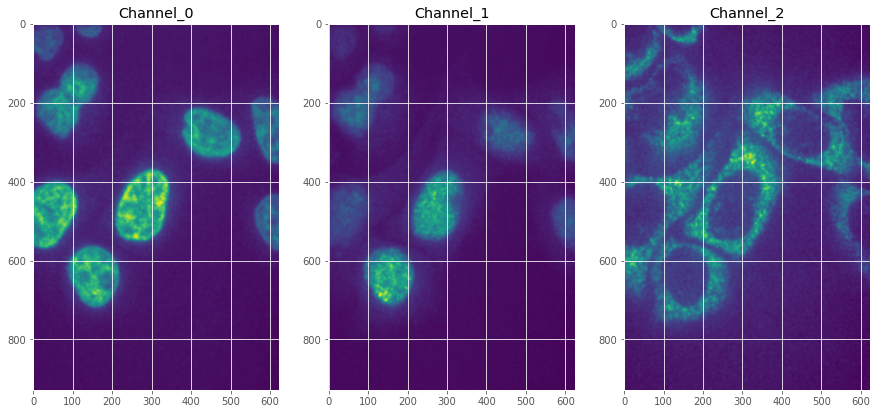

CELL SEGMENTATION
8


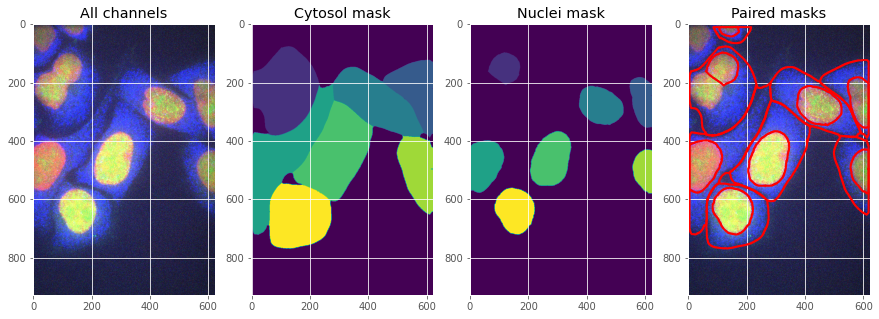

SPOT DETECTION
Spot Detection for Channel : 1
not showing elbow plot
Z-Slice:  7


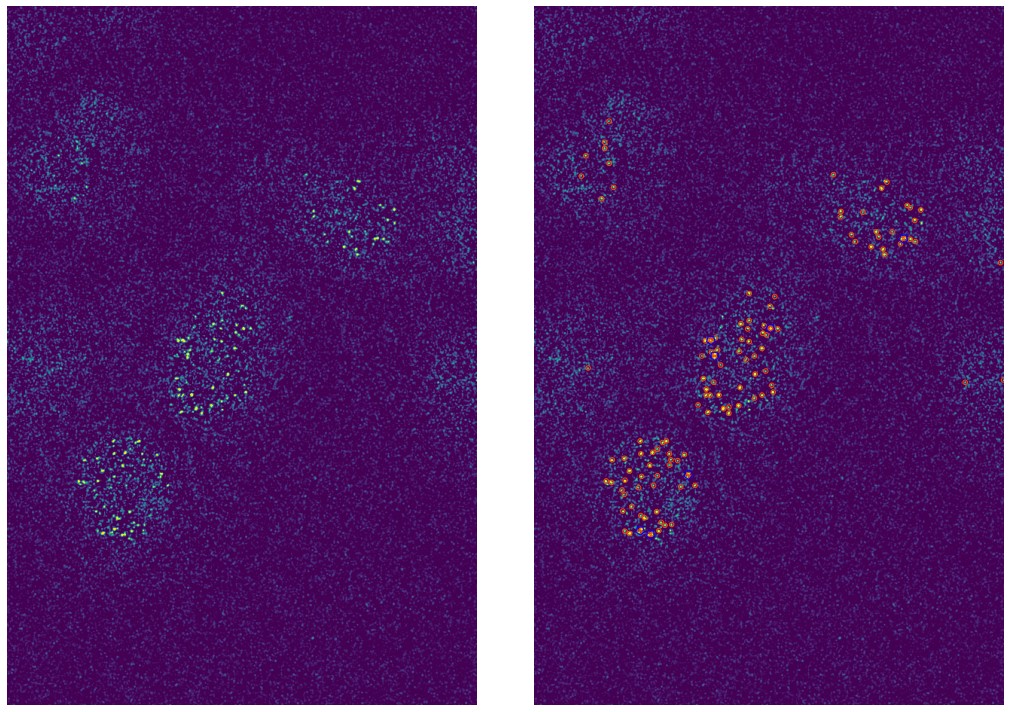

 ___ __  __    _    ____ _____       _ 
|_ _|  \/  |  / \  / ___| ____|  _  / |
 | || |\/| | / _ \| |  _|  _|   (_) | |
 | || |  | |/ ___ \ |_| | |___   _  | |
|___|_|  |_/_/   \_\____|_____| (_) |_|
                                       

ORIGINAL IMAGE
ROI007_XY1620756279_Z00_T0_merged.tif
(14, 928, 624, 3)


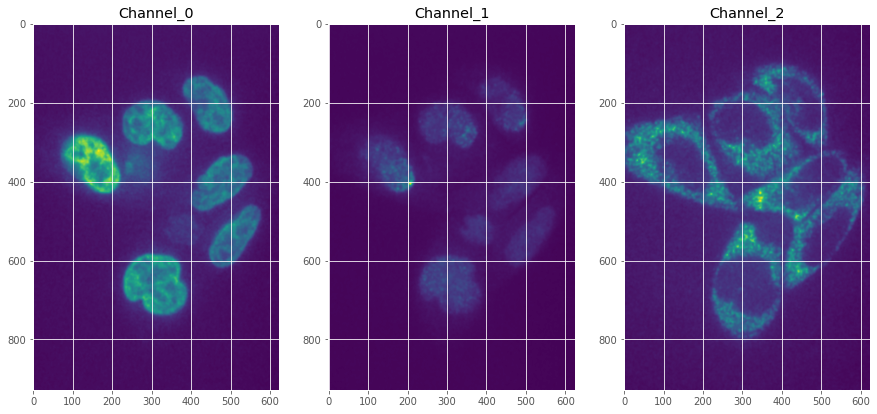

CELL SEGMENTATION
6


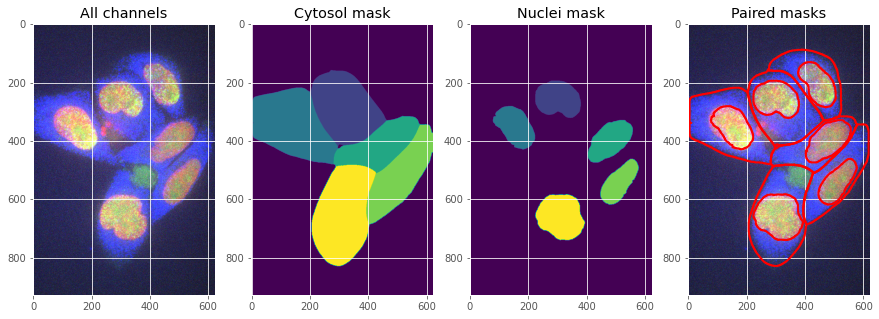

SPOT DETECTION
Spot Detection for Channel : 1
not showing elbow plot
Z-Slice:  7


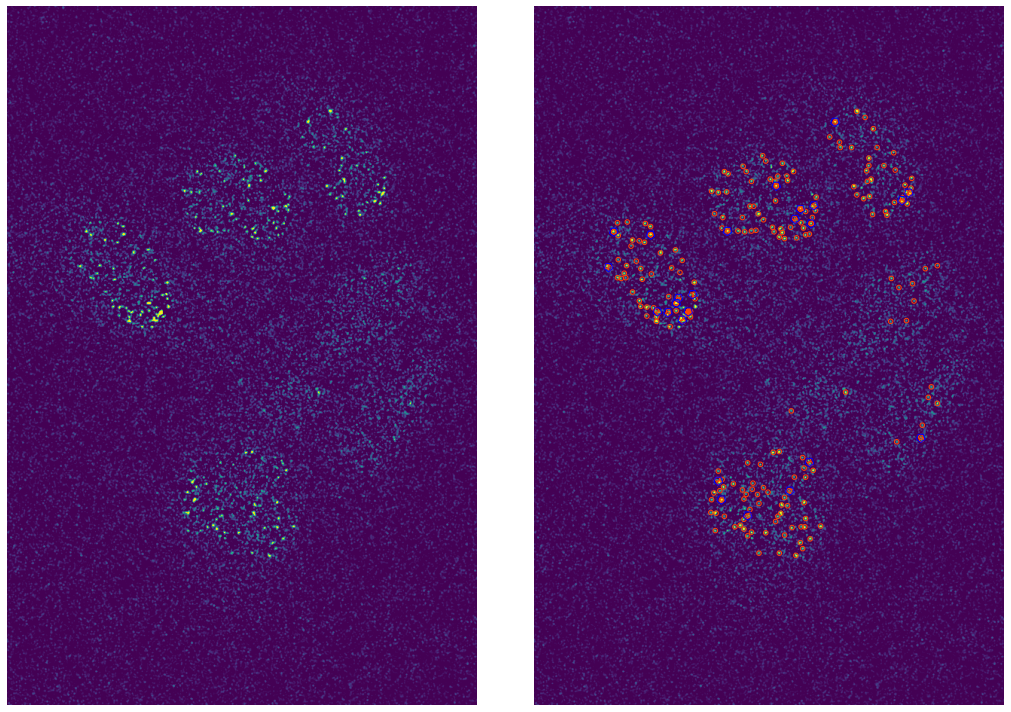

sh: 1: touch./metadata_test_dir.txt: not found


In [6]:
dataframe_FISH,_,_,_= fa.PipelineFISH(data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diamter_nucleus, diameter_cytosol, minimum_spots_cluster,list_voxels=list_voxels, list_psfs=list_psfs ,show_plot=show_plots,file_name_str=remote_folder_path.name).run()

# Extracting data from the dataframe

In [ ]:
dataframe_FISH.tail()

In [ ]:
# Number of cells
spot_type_selected = 0

number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i)  & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]

# Number of spots in cytosol
number_of_spots_per_cell_cytosol = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) & (dataframe_FISH['is_nuc']==False) & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]

# Number of spots in nucleus
number_of_spots_per_cell_nucleus = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected)    ].spot_id) for i in range(0, number_cells)]

# Number of TS per cell.
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['cluster_size'] >=4) ].spot_id) for i in range(0, number_cells)]
#number_of_TS_per_cell= np.asarray(number_of_TS_per_cell)
#number_of_TS_per_cell=number_of_TS_per_cell[number_of_TS_per_cell>0]   
    
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==spot_type_selected)   ].cluster_size.values

# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values

# Plotting

In [ ]:
# Plotting intensity distributions
plt.style.use('ggplot')  # ggplot  #default
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
  n, bins, patches = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
  plt.title(title, size=16)
  return (f)

In [ ]:
#Plotting
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)
#ylab='Probability'
ylab='Frequency Count'  
# adding subplots
f.add_subplot(1,5,1) 
plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,2) 
plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,3) 
plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,4) 
plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,5) 
plot_probability_distribution(number_of_TS_per_cell ,  numBins=20, title='Number TS per cell', xlab='[TS (>= 4 rna)]', ylab=ylab, fig=f, color='orangered')
plt.savefig('plots_'+remote_folder_path.name+'.png')
plt.show()

# Creating folder with results

In [ ]:
# create results folder
if not os.path.exists(str('analysis_'+ remote_folder_path.name)):
    os.makedirs(str('analysis_'+ remote_folder_path.name))

#figure_path 
pathlib.Path().absolute().joinpath('plots_'+ remote_folder_path.name +'.png').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name),'plots_'+ remote_folder_path.name +'.png'))
#metadata_path
pathlib.Path().absolute().joinpath('metadata_'+ remote_folder_path.name +'.txt').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name),'metadata_'+ remote_folder_path.name +'.txt'))
#dataframe_path 
pathlib.Path().absolute().joinpath('dataframe_' + remote_folder_path.name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name),'dataframe_'+ remote_folder_path.name +'.csv'))
#pdf_path 
pathlib.Path().absolute().joinpath('pdf_report_' + remote_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name),'pdf_report_'+ remote_folder_path.name +'.pdf'))

# making a zip file
shutil.make_archive(str('analysis_'+ remote_folder_path.name),'zip',pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name)))

# 

# Sending results to NAS.

In [ ]:
# Writing data to NAS
local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name)+'.zip')
fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, remote_folder_path)

# Removing temporal local files

In [ ]:
#Moving all results to "analyses" folder
if not os.path.exists(str('analyses')):
    os.makedirs(str('analyses'))

analysis_folder_name = str('analysis_'+ remote_folder_path.name)
final_dir_name =pathlib.Path().absolute().joinpath('analyses', analysis_folder_name)

if os.path.exists(str(final_dir_name)):
  shutil.rmtree(str(final_dir_name))
  
pathlib.Path().absolute().joinpath(analysis_folder_name).rename(final_dir_name )


In [ ]:
#Moving all results to "analyses" folder
#if not os.path.exists(str('analyses')):
#    os.makedirs(str('analyses'))
#pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name)).rename(pathlib.Path().absolute().joinpath('analyses', str('analysis_'+ remote_folder_path.name) ))

In [ ]:
# delete local files
shutil.rmtree(local_folder_path)
#shutil.rmtree(str('analysis_'+ remote_folder_path.name))
temp_results_folder_name = pathlib.Path().absolute().joinpath('temp_results_' + remote_folder_path.name)
shutil.rmtree(temp_results_folder_name)
os.remove(pathlib.Path().absolute().joinpath(str('analysis_'+ remote_folder_path.name)+'.zip'))